## Amazon Stock Forecasting in PyTorch with LSTM Neural Network

In [93]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
 
import torch
import torch.nn as nn

data = pd.read_csv('BTC-USD.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
1,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
3,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
4,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095
...,...,...,...,...,...,...,...
1547,2024-03-27,69991.898438,71727.687500,68381.929688,69455.343750,69455.343750,40827113309
1548,2024-03-28,69452.773438,71546.023438,68895.507813,70744.953125,70744.953125,34374900617
1549,2024-03-29,70744.796875,70913.093750,69076.656250,69892.828125,69892.828125,25230851763
1550,2024-03-30,69893.445313,70355.492188,69601.062500,69645.304688,69645.304688,17130241883


In [94]:
data = data[['Date','Close']]
data

,Date,Close
0,2020-01-01,7200.174316
1,2020-01-02,6985.470215
2,2020-01-03,7344.884277
3,2020-01-04,7410.656738
4,2020-01-05,7411.317383
...,...,...
1547,2024-03-27,69455.343750
1548,2024-03-28,70744.953125
1549,2024-03-29,69892.828125
1550,2024-03-30,69645.304688


In [95]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [96]:
data['Date'] = pd.to_datetime(data['Date'])
data['Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1552 entries, 0 to 1551
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
1552 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 12.3 KB


C:\Users\ivoto\AppData\Local\Temp\ipykernel_10076\4140636855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


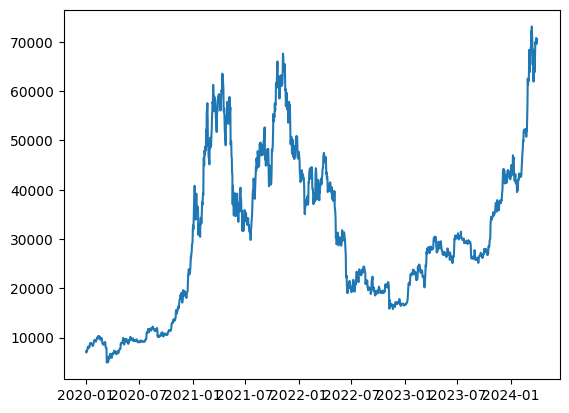

In [97]:
plt.plot(data['Date'],data['Close'])

In [98]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2020-01-08,8079.862793,8163.692383,7769.219238,7411.317383,7410.656738,7344.884277,6985.470215,7200.174316
2020-01-09,7879.071289,8079.862793,8163.692383,7769.219238,7411.317383,7410.656738,7344.884277,6985.470215
2020-01-10,8166.554199,7879.071289,8079.862793,8163.692383,7769.219238,7411.317383,7410.656738,7344.884277
2020-01-11,8037.537598,8166.554199,7879.071289,8079.862793,8163.692383,7769.219238,7411.317383,7410.656738
2020-01-12,8192.494141,8037.537598,8166.554199,7879.071289,8079.862793,8163.692383,7769.219238,7411.317383
...,...,...,...,...,...,...,...,...
2024-03-27,69455.343750,69987.835938,69958.812500,67234.171875,64062.203125,63778.761719,65491.390625,67913.671875
2024-03-28,70744.953125,69455.343750,69987.835938,69958.812500,67234.171875,64062.203125,63778.761719,65491.390625
2024-03-29,69892.828125,70744.953125,69455.343750,69987.835938,69958.812500,67234.171875,64062.203125,63778.761719


En el cuadro aterior vemos para el dia actual, y los precios de los 7 (n-dias) anteriores

In [99]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 8079.862793,  8163.692383,  7769.219238, ...,  7344.884277,
         6985.470215,  7200.174316],
       [ 7879.071289,  8079.862793,  8163.692383, ...,  7410.656738,
         7344.884277,  6985.470215],
       [ 8166.554199,  7879.071289,  8079.862793, ...,  7411.317383,
         7410.656738,  7344.884277],
       ...,
       [69892.828125, 70744.953125, 69455.34375 , ..., 67234.171875,
        64062.203125, 63778.761719],
       [69645.304688, 69892.828125, 70744.953125, ..., 69958.8125  ,
        67234.171875, 64062.203125],
       [70466.28125 , 69645.304688, 69892.828125, ..., 69987.835938,
        69958.8125  , 67234.171875]])

In [100]:
#Normalizamos los datos 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np.shape

(1545, 8)

- Hasta ahora, leemos el CSV, lo convertimos a DataFrame con pandas
- Luego lo analizamos y para trabajar con el lo pasamos de DataFrame a una matriz de NumPy 
- Y por ultimo Escalamos las variables con un rango de -1 a 1 

#### Division del conjunto de entrenamiento y test

In [101]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((1545, 7), (1545,))

In [102]:
X = dc(np.flip(X, axis=1 ))
X

array([[-0.93453832, -0.9408427 , -0.93028919, ..., -0.92833851,
        -0.9178294 , -0.90624645],
       [-0.9408427 , -0.93028919, -0.92835791, ..., -0.9178294 ,
        -0.90624645, -0.90870795],
       [-0.93028919, -0.92835791, -0.92833851, ..., -0.90624645,
        -0.90870795, -0.91460381],
       ...,
       [ 0.72678409,  0.73510681,  0.82824563, ...,  0.90910172,
         0.8934661 ,  0.93133303],
       [ 0.73510681,  0.82824563,  0.90824951, ...,  0.8934661 ,
         0.93133303,  0.906312  ],
       [ 0.82824563,  0.90824951,  0.90910172, ...,  0.93133303,
         0.906312  ,  0.89904395]])

In [103]:
split_index = int(len(X) * 0.95)

split_index

1467

In [104]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1467, 7), (78, 7), (1467,), (78,))

#### Agregamos un dimension

In [105]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1467, 7, 1), (78, 7, 1), (1467, 1), (78, 1))

#### Convertimos a los conjuntos a Tensores de Pytorch 

In [106]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1467, 7, 1]),
 torch.Size([78, 7, 1]),
 torch.Size([1467, 1]),
 torch.Size([78, 1]))

In [107]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [108]:
x_sample, y_sample = train_dataset[10]
print(x_sample.shape)  # Imprimirá torch.Size([7, 1])
print(y_sample.shape)  # Imprimirá torch.Size([1])

torch.Size([7, 1])
torch.Size([1])


In [109]:
from torch.utils.data import DataLoader

batch_size = 16 
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [110]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


#### Creamos el modelo

In [111]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

#### Funcion y Bucle de entrenamiento 

In [112]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) #Pasamos el conjunto de train con sus etiquetas

        output = model(x_batch) 
        loss = loss_function(output, y_batch) #Calculamos el loss con el valor pred y el real
        running_loss += loss.item() #Perdida acumulada 

        optimizer.zero_grad() #Seteamos los gradientes en cero
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99: #Print every 100 batches 
            avg_loss_across_batches = running_loss / 100 #Perdida promedio en 100 lotes 
            print('Batch {0}, loss: {1:.3}'.format(batch_index+1, avg_loss_across_batches))
            running_loss = 0.0
    print()


In [113]:
def validate_one_epoch():
    model.train(False) #Evaluate mode
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) #Pasamos el conjunto de test con sus etiquetas

        with torch.no_grad(): #No necesitamos calcular los gradientes
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    
    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()


In [114]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1



Val Loss: 0.395
***************************************************

Epoch: 2

Val Loss: 0.326
***************************************************

Epoch: 3

Val Loss: 0.207
***************************************************

Epoch: 4

Val Loss: 0.156
***************************************************

Epoch: 5

Val Loss: 0.132
***************************************************

Epoch: 6

Val Loss: 0.116
***************************************************

Epoch: 7

Val Loss: 0.100
***************************************************

Epoch: 8

Val Loss: 0.088
***************************************************

Epoch: 9

Val Loss: 0.077
***************************************************

Epoch: 10

Val Loss: 0.069
***************************************************

Epoch: 11

Val Loss: 0.061
***************************************************

Epoch: 12

Val Loss: 0.056
***************************************************

Epoch: 13

Val Loss: 0.049
*******************************

### Visualizacion

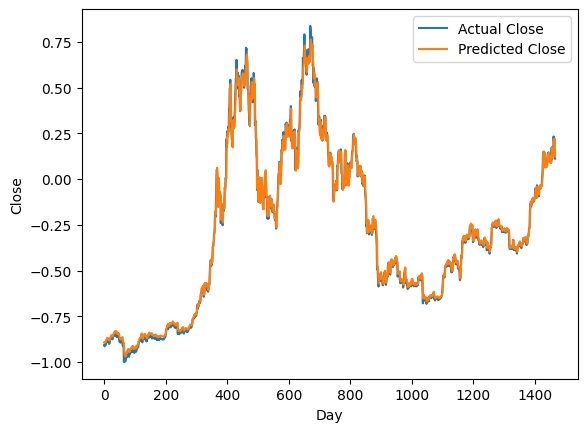

In [115]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy() #Es porque numpy no usa GPU 

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

##### Anti-transformada de los Precios 

In [116]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 8608.93930642,  8647.36969505,  8534.59968608, ...,
       46521.66205377, 46317.92740423, 43253.9925073 ])

In [117]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 8079.86376967,  7879.07046987,  8166.55340504, ...,
       46368.58601286, 42853.16788779, 42842.38293877])

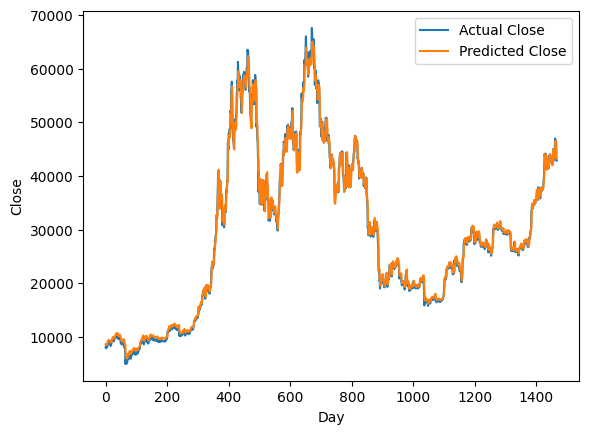

In [118]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [119]:
X_test.shape


torch.Size([78, 7, 1])

In [120]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([42537.48864428, 41573.3115633 , 42102.35766625, 42871.77740561,
       42725.85479221, 41401.97438907, 41416.86687514, 41514.01768776,
       41461.48445078, 39685.05942664, 39627.08296723, 39902.37625082,
       39887.55075202, 41546.9987642 , 42165.71949546, 42156.85890776,
       43158.57016901, 43040.53861517, 42632.30403739, 42932.24863302,
       43094.13654362, 42951.14411541, 42552.49582065, 42534.1423261 ,
       42912.4417179 , 44060.00403797, 45132.59746343, 46858.17103682,
       47678.61984467, 48188.51977048, 49559.91444082, 49644.23922288,
       51234.8557945 , 51663.06475556, 51895.3572924 , 51537.36214539,
       51774.39859826, 51564.02003038, 51890.7057376 , 51636.79153984,
       51159.17439903, 50591.72734125, 51104.47727052, 51373.07182802,
       53541.92548123, 55913.1019767 , 60030.47397237, 60325.24227965,
       61213.66996292, 61257.41670417, 61959.53048559, 64945.94031492,
       63557.63948086, 64434.11298292, 65114.88624693, 66035.92860663,
      

In [121]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([41796.26952682, 42511.9687815 , 43154.94524473, 42742.65235538,
       41262.05855381, 41618.40616944, 41665.58600782, 41545.78512758,
       39507.36718492, 39845.55075434, 40077.07420638, 39933.80856403,
       41816.87115445, 42120.05473639, 42035.59369615, 43288.24634171,
       42952.60946174, 42582.6055795 , 43075.77340697, 43185.85935819,
       42992.24993464, 42583.58196958, 42658.6680919 , 43084.67180187,
       44318.22267473, 45301.566232  , 47147.19924631, 47771.27743601,
       48293.91813587, 49958.22272448, 49742.44153251, 51826.6953499 ,
       51938.5549411 , 52160.20360816, 51662.99573838, 52122.54661791,
       51779.1445442 , 52284.87502049, 51839.17933945, 51304.97217253,
       50731.94893276, 51571.10139583, 51733.23797126, 54522.4027957 ,
       57085.37092405, 62504.78852065, 61198.382658  , 62440.6329939 ,
       62029.84681044, 63167.37169843, 68330.41483787, 63801.199072  ,
       66106.80518857, 66925.48492375, 68300.09396766, 68498.88373939,
      

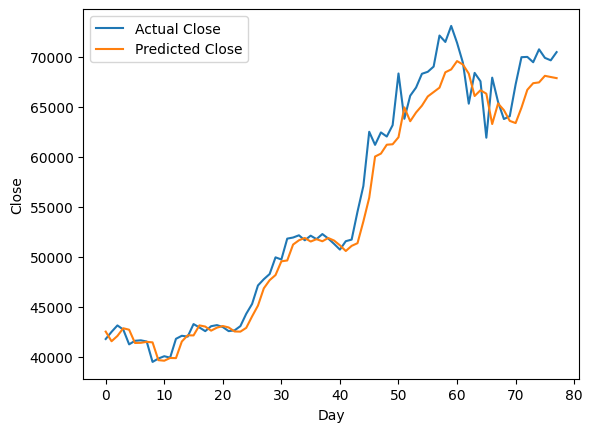

In [122]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()